In [1]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import decord
from decord import cpu, gpu
import numpy as np
import torchvision.transforms as T
import ast
import sys
import os

sys.path.append("models/LAVIS")
from lavis.models import load_model_and_preprocess

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device1 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device2 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device, device1)

cuda:0 cuda:1


In [3]:
def get_video(video_path, fps=30):
        # If fixed width and height are required, VideoReader takes width and height as arguments.
        video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
        decord.bridge.set_bridge('torch')
        vlen = len(video_reader)
        print(vlen)
        original_fps = video_reader.get_avg_fps()
        print(original_fps)
        num_frames = int(vlen * fps / original_fps)
        # num_frames = min(self.max_num_frames, num_frames)
        frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(np.int_)
        video = video_reader.get_batch(frame_idxs).byte()
        video = video.permute(0, 3, 1, 2)
        return video

In [4]:
video_id = 3489439407
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')
video.shape

1662
29.97002997002997


torch.Size([1663, 3, 480, 640])

In [6]:

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device1)
# preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/vit-so400m-14-siglip-384')

# model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP')
# model = model.to(device2)
# tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["lady in blue standing listening to her headphones"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device1)
text = tokenizer(labels_list, context_length=model.context_length).to(device1)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

Image features shape:  torch.Size([167, 1152]) Text features shape:  torch.Size([1, 1152])


133/167


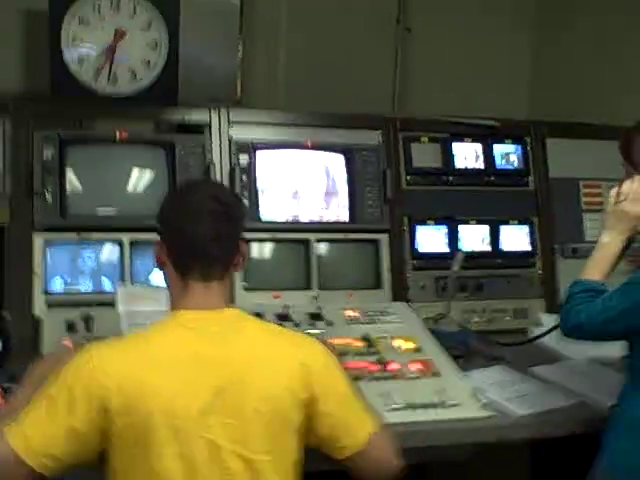

In [7]:
raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{len(images)}")
raw_image

In [9]:
from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device1)
# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device1)
# generate caption
model.generate({"image": image})
# ['a large fountain spewing water into the air']

['a man and a woman standing in front of a control room']

In [10]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device1)
# ask a random question.
question = "What is the man doing in the video?"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device1)
question = txt_processors["eval"](question)
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

['talking on phone']

In [5]:
import openai

# with open('api.key') as f:
#     openai.api_key = f.read().strip()
# with open('api_org.key') as f:
#     openai.organization = f.read().strip()

def call_llm(prompt):
    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "Follow the directions given in the next prompt carefully."},
        {"role": "user", "content": prompt}
      ]
    )
    output_message = completion.choices[0].message.content
    return output_message

In [6]:
def get_answer_helper(question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    # with open('./prompts/base_prompt.txt') as f:
    with open('./prompts/base_prompt_temporal.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(answer_choices))
    prompt = prompt.replace('insert_curr_frame', str(curr_frame))
    prompt = prompt.replace('insert_total_frames', str(total_frames))
    prompt = prompt.replace('insert_caption', caption[0])

    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [7]:
def final_select(question, choices, info):
    with open('./prompts/final_prompt.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(choices))
    prompt = prompt.replace('insert_info', str(info))
    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [8]:
def query_VQA(vqa_question, frame):
    print("CALLING VQA: ", vqa_question)
    model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device1)
    # ask a random question.
    question = vqa_question
    image = vis_processors["eval"](frame).unsqueeze(0).to(device1)
    question = txt_processors["eval"](question)
    answer = model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")
    print("VQA ANSWER: ", answer)
    return answer

In [9]:
def query_caption(frame):
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device1)
    image = vis_processors["eval"](frame).unsqueeze(0).to(device1)
    caption = model.generate({"image": image})
    return caption

In [10]:
def get_answer(images, question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    LIMIT = 10
    goto_frame = curr_frame
    VQA_question = None
    info = {}
    caption = caption
    while LIMIT >= 0:
        print(f"CALL {10 - LIMIT}")
        print("ALL INFO:", info)
        if f"Frame {goto_frame}" not in info:
            info[f"Frame {goto_frame}"] = {}
        LIMIT -= 1  
        if goto_frame != None:
            raw_image = images[goto_frame] 
        caption = query_caption(raw_image)
        print(caption)
        output = get_answer_helper(question, answer_choices, goto_frame, total_frames, caption, prev_info)
        print(output)
        if output["Answer"] != None:
            print("here1")
            return output["Answer"]
        else:
            info[f"Frame {goto_frame}"]["caption"] = caption
            if output["Choose Frame"] != None:
                goto_frame = output["Choose Frame"]
            if output["VQA Question"] != None:
                VQA_question = output["VQA Question"]
                vqa_result = query_VQA(VQA_question, raw_image)
                info[f"Frame {curr_frame}"][VQA_question] = vqa_result
            else:
                continue       
    # case for when we run out of tries
    final_output = final_select(question, answer_choices, info)
    return final_output

In [11]:
def answer_question(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    # model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    # model = model.to(device)
    # preprocess = preprocess
    # tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP')
    model = model.to(device)
    tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device1)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device1)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    return result

In [12]:
def answer_question_half(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    # model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    # model = model.to(device)
    # preprocess = preprocess
    # tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP')
    model = model.to(device)
    tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device1)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device1)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    return images, caption
    #result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    #return result

# In Context Example

926
29.97002997002997
52/93
['a dog and a cat are sitting on a couch']


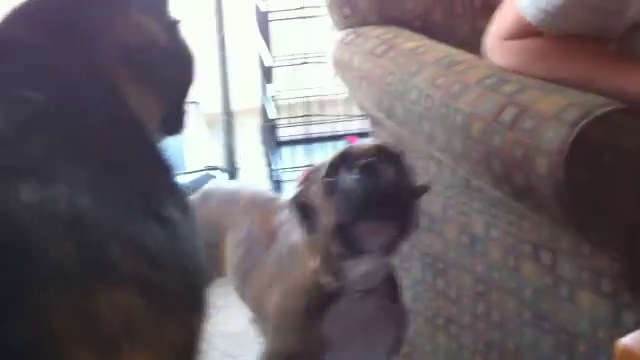

In [104]:
# video_id = 3954996353
video_id = 4825249972
question = "what did the brown dog do before it started chasing the cat"
options = ['climbing over it', 'lying down', 'jump on the sofa and bark', 'sit and watch', 'walk back']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP')
model = model.to(device)
tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["dog is chasing the cat"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

raw_image = images[indices[0][0].item()]
print(f"{indices[0][0].item()}/{len(images)}")

from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device1)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device1)
caption = model.generate({"image": image})
print(caption)
raw_image

In [156]:
image = vis_processors["eval"](images[53]).unsqueeze(0).to(device1)

In [157]:
new_caption = model.generate({"image": image})
new_caption

['a small dog standing next to a person on a couch']

In [171]:
query_VQA("what is the dog's action?", images[53])

CALLING VQA:  what is the dog's action?
VQA ANSWER:  ['standing']


['standing']

In [146]:
result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
result

{'Enough Information?': True, 'Answer': 0, 'Choose Frame': None, 'VQA Question': None}


0

# Temporal Previous (TP) Examples

# Q1

1600
29.97002997002997
1600
29.97002997002997
58/161
['a man riding a motorcycle down a dirt road']


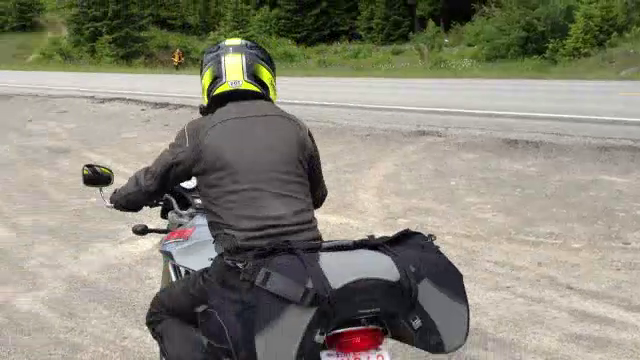

In [21]:
video_id = 7499375636
question = "what did the man in black at the back do before the man with black and green helmet drove away?"
options = ['looking at them', 'step back', 'adjusting helmet', 'driving off', 'raise his hand out the window']
# correct answer: 1
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "man with black and green helmet driving away")

In [22]:
output = get_answer(images, question, options, 58, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}
['a man riding a motorcycle down a dirt road']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 52, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 52, 'VQA Question': None}
CALL 1
ALL INFO: {'Frame 58': {'caption': ['a man riding a motorcycle down a dirt road']}}
['a man sitting on a motorcycle with a helmet on']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 56, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 56, 'VQA Question': None}
CALL 2
ALL INFO: {'Frame 58': {'caption': ['a man riding a motorcycle down a dirt road']}, 'Frame 52': {'caption': ['a man sitting on a motorcycle with a helmet on']}}
['a person wearing a helmet sitting on a motorcycle']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 50, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 50, 'VQA Q

2

# Q2

536
29.97002997002997
536
29.97002997002997
10/54
['a woman riding a bike down a sidewalk next to a man']


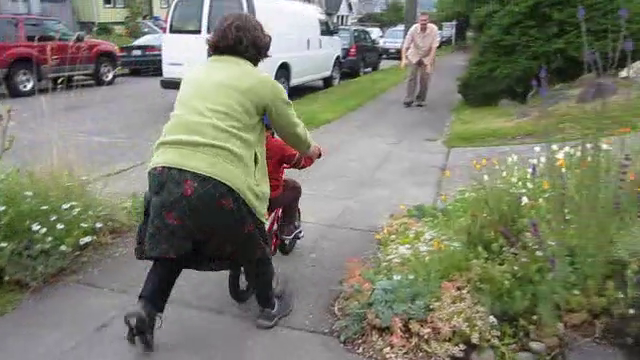

In [19]:
video_id = 7533973826
question = "what did the woman do before she let go of the boy cycling?"
options = ['move forward', 'sit on sofa', 'hold his hands while pushing him', 'stop riding', 'look at girl']
# correct answer: 2
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "woman lets go of the boy cycling")

In [20]:
output = get_answer(images, question, options, 10, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}
['a woman riding a bike down a sidewalk next to a man']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 5, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 5, 'VQA Question': None}
CALL 1
ALL INFO: {'Frame 10': {'caption': ['a woman riding a bike down a sidewalk next to a man']}}
['a woman teaching a child how to ride a bike']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 1, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 1, 'VQA Question': None}
CALL 2
ALL INFO: {'Frame 10': {'caption': ['a woman riding a bike down a sidewalk next to a man']}, 'Frame 5': {'caption': ['a woman teaching a child how to ride a bike']}}
['a woman and a child riding a bike down a sidewalk']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 6, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Fra

2

# Q3

720
29.97002997002997
720
29.97002997002997
51/72
['a little girl sitting on a couch in a living room']


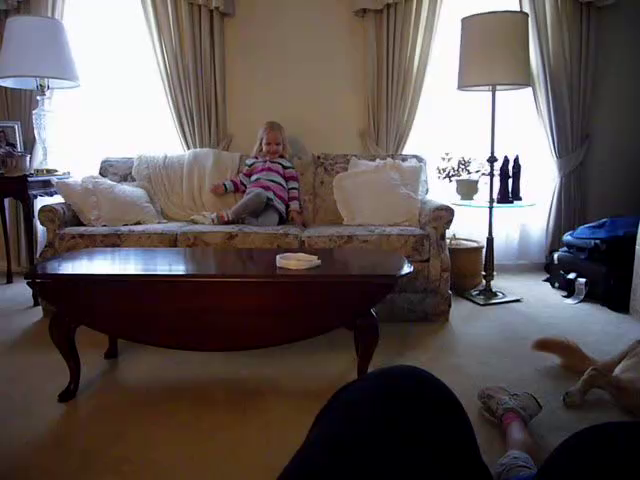

In [27]:
video_id = 4144360777
question = "what did the girl in striped do before going up the sofa?"
options = ['pet', 'walking around the table', 'lie on her stomach', 'playing with sofa', 'hold another toy']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "the girl in striped is up on the sofa")

In [46]:
output = get_answer(images, question, options, 51, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}
['a little girl sitting on a couch in a living room']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 37, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 37, 'VQA Question': None}
CALL 1
ALL INFO: {'Frame 51': {'caption': ['a little girl sitting on a couch in a living room']}}
['a little girl sitting on the floor in a living room']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 19, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 19, 'VQA Question': None}
CALL 2
ALL INFO: {'Frame 51': {'caption': ['a little girl sitting on a couch in a living room']}, 'Frame 37': {'caption': ['a little girl sitting on the floor in a living room']}}
['a blurry photo of a child laying on the floor']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 35, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None,

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 output = get_answer(images, question, options, 51, len(images)-1, caption, None)             │
│   2 output                                                                                       │
│   3                                                                                              │
│                                                                                                  │
│ in get_answer:19                                                                                 │
│                                                                                                  │
│   16 │   │   print(caption)                                                                      │
│   17 │   │   output = get_answer_helper(question, answer_choices, goto_frame, total_frames, c    │
│   18 │   │   print(output)                                                                       │
│ ❱ 19 │   │   if output["Answer"] != None:                                                        │
│   20 │   │   │   print("here1")                                                                  │
│   21 │   │   │   return output["Answer"]                                                         │
│   22 │   │   else:                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'NoneType' object is not subscriptable

# Q4

1755
29.97002997002997
1755
29.97002997002997
11/176
['a group of men standing next to each other']


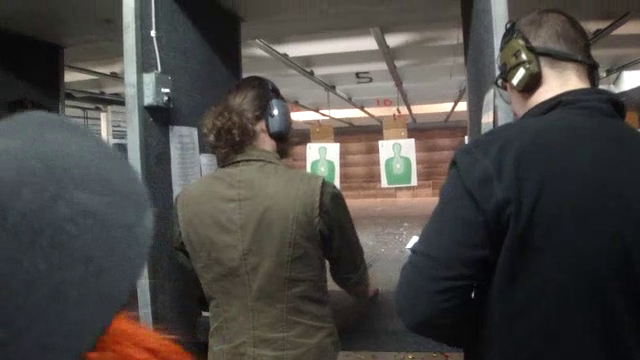

In [49]:
video_id = 6813862571
question = "what did the man in green do before he fired a shot?"
options = ['scream', 'aim at target', 'talk', 'get off stage', 'choke']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "the man in green has fired a shot")

In [ ]:
output = get_answer(images, question, options, 51, len(images)-1, caption, None)
output

# Q5

2158
23.976023976023978
2158
23.976023976023978
72/270
['a group of people that are playing guitars']


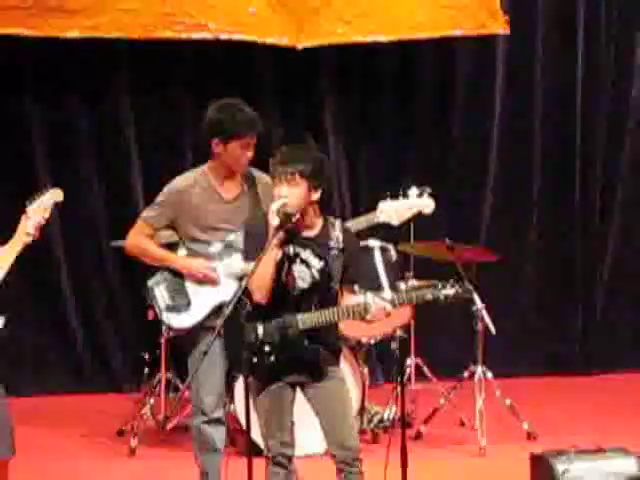

In [54]:
video_id = 2797596111
question = "what did the boy in black do before he started singing at the beginning of the video?"
options = ['drink from it', 'pick little boy up', 'plays the guitar', 'looking at toy on ground', 'throw it at dog']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "the boy in black is singing")

In [ ]:
output = get_answer(images, question, options, 72, len(images)-1, caption, None)
output

1721
29.97
1721
29.97
31/173
['a boy and a girl sitting on a couch']


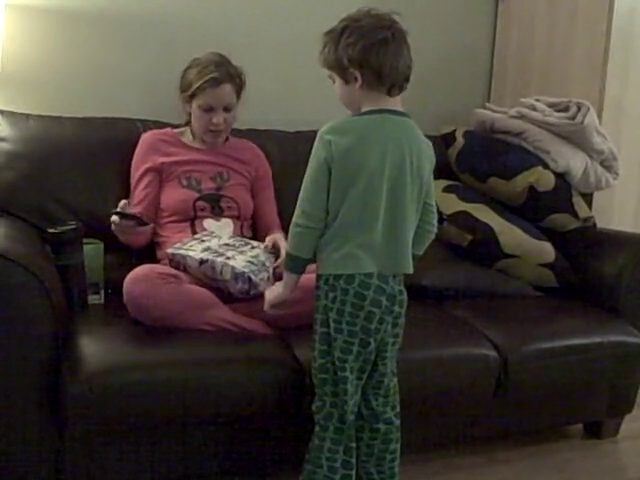

In [29]:
video_id = 11566980553
question = "how does the woman respond after the boy gives her the present?"
options = ['smile', 'puts present aside and ignore him', 'write something down', 'cry', 'walk back to the man']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "woman recieving present from boy")

In [30]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}


['a young boy standing in a living room holding a nintendo wii controller']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 150, 'VQA Question': 'What does the man do after the boy gives the present?'}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 150, 'VQA Question': 'What does the man do after the boy gives the present?'}
CALLING VQA:  What does the man do after the boy gives the present?
VQA ANSWER:  ['play wii']
CALL 1
ALL INFO: {'Frame 3': {'caption': ['a young boy standing in a living room holding a nintendo wii controller'], 'What does the man do after the boy gives the present?': ['play wii']}}
['a young boy sitting on the floor reading a book']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 150, 'VQA Question': "What is the woman's reaction to the boy's present?"}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 150, 'VQA Question': "What is the woman's reaction to the boy's present

In [47]:
final_select(question, options, {'Frame 3': {'caption': ['a young boy standing in a living room holding a nintendo wii controller'], 'What does the man do after the boy gives the present?': ['play wii'], "What is the woman's reaction to the boy's present?": ['happy'], "What is the woman's reaction to the boy's gift?": ['happy'], 'What is the woman doing in the video?': ['eating'], 'What are the kids doing on top of the couch?': ['playing'], 'What is happening in the video?': ['playing wii']}, 'Frame 150': {'caption': ['a young boy sitting on the floor reading a book']}, 'Frame 30': {'caption': ['a couple of kids sitting on top of a couch']}, 'Frame 133': {'caption': ['a young boy sitting on the floor holding a wii remote']}})

TypeError: replace() argument 2 must be str, not list

- Image level allows you to go back and forth in time, can't do in video-models
    - Binary search aspect -> start in middle -> move forward if not
    - Exponential or recursive
- Image level leveraging for video -> algorithm efficiency analysis
- Show that it works for multiple datasets
- List of different datasets other than NextQA